# LIBRARIES

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# DATA INFERENCE

In [2]:
# Initialize the random generator with a seed
rng = np.random.default_rng(seed=7)

# Generate the random data
cont = rng.choice(['One Year', 'Two Years', 'Month-to-Month'], size=20000)
offer = rng.choice(['None', 'Offer A', 'Offer B', 'Offer C', 'Offer D', 'Offer E'], size=20000)
onl = rng.choice(['Yes', 'No', 'No Internet'], size=20000)
prem = rng.choice(['Yes', 'No', 'No Internet'], size=20000)
dev = rng.choice(['Yes', 'No', 'No Internet'], size=20000)
tenu = rng.uniform(1, 72, 20000)
ref = rng.uniform(0, 11, 20000)
rev = rng.uniform(21.61, 11979.34, 20000)

# Create the DataFrame
new_data_inf = pd.DataFrame({
    'contract': cont,
    'offer': offer,
    'online_security': onl,
    'premium_tech_support': prem,
    'device_protection_plan': dev,
    'tenure_in_months': tenu,
    'number_of_referrals': ref,
    'total_revenue': rev,
})

# Modify the DataFrame based on the condition
# If 'online_security' is 'No Internet'
new_data_inf.loc[new_data_inf['online_security'] == 'No Internet', ['premium_tech_support', 'device_protection_plan']] = 'No Internet'

# If 'online_security' is 'Yes'
new_data_inf.loc[new_data_inf['online_security'] == 'Yes', ['premium_tech_support', 'device_protection_plan']] = 'Yes'

# If 'online_security' is 'No'
new_data_inf.loc[new_data_inf['online_security'] == 'No', ['premium_tech_support', 'device_protection_plan']] = 'No'
'''
Explaination

If the value in 'Online Security' column is 'No Internet' so is 'Premium Tech Support' & 'Device Protection Plan'
'''

new_data_inf

,contract,offer,online_security,premium_tech_support,device_protection_plan,tenure_in_months,number_of_referrals,total_revenue
0,Month-to-Month,Offer D,No Internet,No Internet,No Internet,27.985899,3.127835,3435.212532
1,Two Years,Offer C,No,No,No,36.977094,9.653383,6431.811728
2,Month-to-Month,Offer D,No,No,No,56.949639,9.942211,1884.938786
3,Month-to-Month,Offer E,No Internet,No Internet,No Internet,28.916189,10.553698,2272.917413
4,Two Years,None,Yes,Yes,Yes,37.807770,0.187432,442.255377
...,...,...,...,...,...,...,...,...
19995,Month-to-Month,None,No,No,No,53.914450,0.359088,3941.976767
19996,Month-to-Month,Offer E,No Internet,No Internet,No Internet,49.410604,3.810527,11553.353799
19997,Two Years,None,No Internet,No Internet,No Internet,46.504847,10.446049,7691.856016
19998,Month-to-Month,Offer A,Yes,Yes,Yes,56.533604,6.200644,8248.058403


## Predict Classification, Filter, & Predict Cluster

In [3]:
# Custom transformer to filter churned customers and select features
class FilterAndSelect(BaseEstimator, TransformerMixin):
    def __init__(self, churn_column='cust_stat_pred', selected_features=None):
        self.churn_column = churn_column
        self.selected_features = selected_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        churned_customers = X[X[self.churn_column] == 1]
        if self.selected_features:
            return churned_customers[self.selected_features]
        return churned_customers

# Step 1: Load the pipelines
with open("fp_classifier.pkl", "rb") as f:
    classification_pipeline = pickle.load(f)
    
with open("clustering_pipeline_with_filter.pkl", "rb") as f:
    clustering_pipeline = pickle.load(f)

# Step 2: Run Classification
classification_predictions = classification_pipeline.predict(new_data_inf)

# Add the classification results back to the original DataFrame
new_data_inf['cust_stat_pred'] = classification_predictions

# Step 3: Run Clustering
# Note: The clustering pipeline includes the filtering step for 'Churned' status
clustering_predictions = clustering_pipeline.predict(new_data_inf)

# Step 4: Append Results
# Create a DataFrame to merge back into the original DataFrame
result_df = pd.DataFrame({
    'Index': new_data_inf[new_data_inf['cust_stat_pred'] == 1].index,
    'Cluster': clustering_predictions
})

# Remove index from result_df
result_df.reset_index(drop=True, inplace=True)

# Merge the results back into the original DataFrame
final_data = pd.merge(new_data_inf, result_df, how='left', left_index=True, right_on='Index')

In [4]:
# Filter final_data to only show rows that are flagged as 'Churned'
final_data_churned = final_data[final_data['cust_stat_pred'] == 1]

final_data_churned = final_data_churned[['contract', 'offer', 'online_security', 'premium_tech_support',
             'device_protection_plan', 'tenure_in_months', 'number_of_referrals',
             'total_revenue', 'cust_stat_pred', 'Cluster']]

# Display the DataFrame
final_data_churned

,contract,offer,online_security,premium_tech_support,device_protection_plan,tenure_in_months,number_of_referrals,total_revenue,cust_stat_pred,Cluster
0.0,Two Years,None,Yes,Yes,Yes,37.807770,0.187432,442.255377,1,2.0
1.0,Month-to-Month,None,No,No,No,6.286701,4.785165,9559.342951,1,1.0
2.0,Month-to-Month,Offer D,Yes,Yes,Yes,17.969300,1.236911,5085.487240,1,2.0
3.0,Month-to-Month,Offer E,No,No,No,9.610252,2.762045,2977.195386,1,0.0
4.0,Month-to-Month,Offer E,No,No,No,37.530705,0.126047,4053.088332,1,0.0
...,...,...,...,...,...,...,...,...,...,...
2266.0,Month-to-Month,None,No,No,No,9.818216,5.272342,4962.785971,1,1.0
2267.0,Month-to-Month,Offer B,No,No,No,9.841081,2.357350,4605.211551,1,0.0
2268.0,One Year,Offer C,Yes,Yes,Yes,61.244848,0.498807,4963.234281,1,2.0
2269.0,Month-to-Month,Offer A,No,No,No,18.423718,1.197914,1282.916020,1,0.0


# EXPLORATORY DATA ANALYSIS (EDA) CLUSTER

In this section we use `df_eda`

In [5]:
df_eda = final_data_churned.copy()

## Value Counts of Cluster

In [6]:
df_eda['Cluster'].value_counts()

0.0    1225
2.0     723
1.0     323
Name: Cluster, dtype: int64

Seems the majority of the data are `Cluster 0`

## Basic Numeric Description

In [7]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2271 entries, 0.0 to 2270.0
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   contract                2271 non-null   object 
 1   offer                   2271 non-null   object 
 2   online_security         2271 non-null   object 
 3   premium_tech_support    2271 non-null   object 
 4   device_protection_plan  2271 non-null   object 
 5   tenure_in_months        2271 non-null   float64
 6   number_of_referrals     2271 non-null   float64
 7   total_revenue           2271 non-null   float64
 8   cust_stat_pred          2271 non-null   int64  
 9   Cluster                 2271 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 195.2+ KB


In [8]:
df_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure_in_months,2271.0,29.313958,21.489365,1.002677,7.986915,28.260524,47.022078,71.953807
number_of_referrals,2271.0,2.068262,2.163857,0.001583,0.654229,1.397160,2.727417,10.983740
total_revenue,2271.0,6499.578730,3211.422413,27.888419,4002.934714,6670.785741,9182.901505,11969.459364
cust_stat_pred,2271.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Cluster,2271.0,0.778952,0.899592,0.000000,0.000000,0.000000,2.000000,2.000000


## Cluster Distribution in Columns Average Values

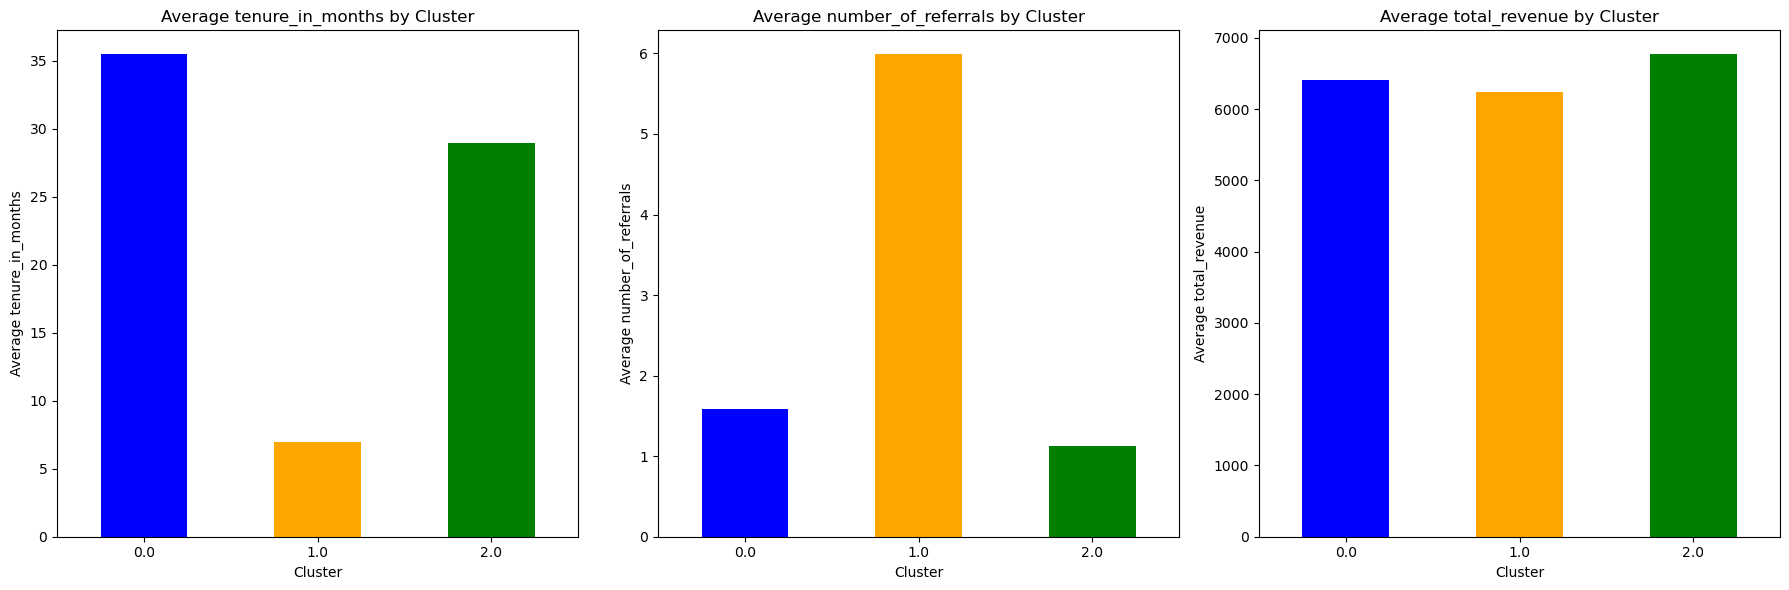

In [9]:
agg_data = df_eda.groupby(['Cluster']).agg({'tenure_in_months': 'mean',
                                            'number_of_referrals': 'mean',
                                            'total_revenue': 'mean'})

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for ax, column in zip(axes, agg_data.columns):
    agg_data[column].plot(kind='bar', color=['blue', 'orange', 'green'], ax=ax)
    ax.set_title(f'Average {column} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f'Average {column}')
    ax.set_xticks(range(len(agg_data[column])))
    ax.set_xticklabels(agg_data.index, rotation=0)

plt.tight_layout()
plt.show()

**Average Tenure**
- Cluster 1 have `lowest` tenure

**Average Referrals**
- Cluster 1 have `highest` referrals to other people

**Average Revenue**
- All cluster tends to have `similiar` value

## Numerical Column Pairplot

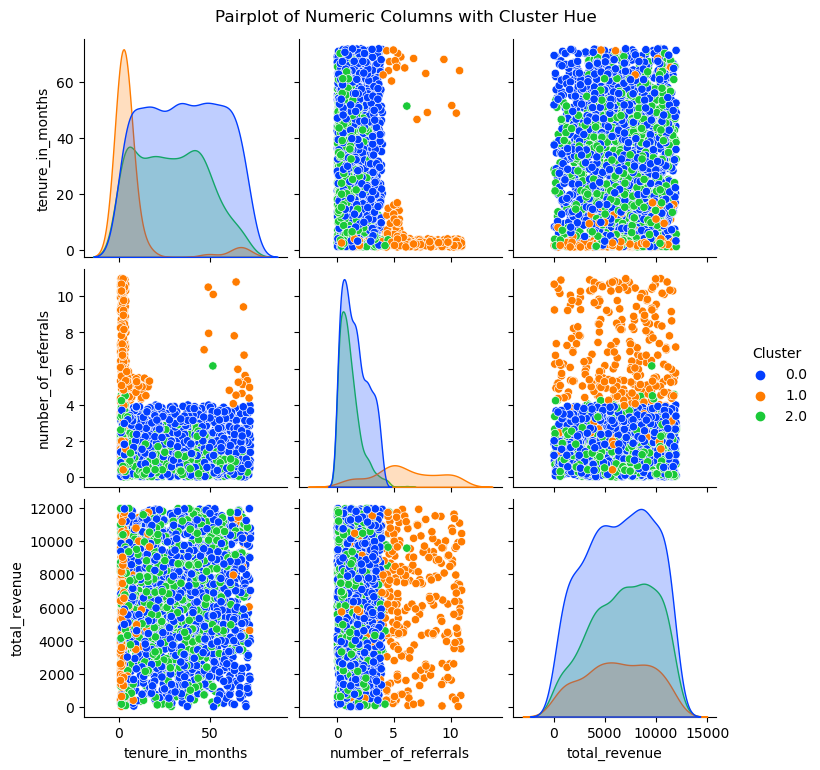

In [10]:
import seaborn as sns
num_col=['tenure_in_months','number_of_referrals','total_revenue']
sns.pairplot(df_eda, hue='Cluster', vars=num_col, palette='bright', diag_kind='kde')
plt.suptitle('Pairplot of Numeric Columns with Cluster Hue', y=1.02)
plt.show()

From this pairplot, the visualization that draw our attention are:
- Total Revenue with Tenure
- Total Revenue with Number of Referrals

### Customer Revenue and Tenure Correlation

Analize correlation of customer revenue with their tenure

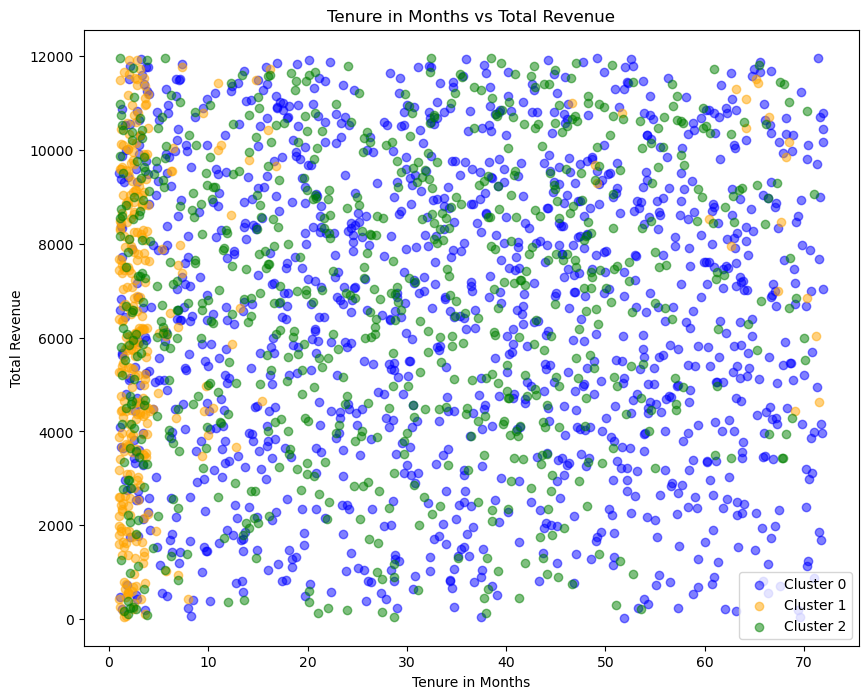

In [11]:
plt.figure(figsize=(10, 8))
colors = {0.0: 'blue', 1.0: 'orange', 2.0: 'green'}
for cluster, color in colors.items():
    subset = df_eda[df_eda['Cluster'] == cluster]
    plt.scatter(subset['tenure_in_months'], subset['total_revenue'], c=color, label=f'Cluster {int(cluster)}', alpha=0.5)

plt.title('Tenure in Months vs Total Revenue')
plt.xlabel('Tenure in Months')
plt.ylabel('Total Revenue')
plt.legend()
plt.show()

Customer on Cluster 1 tends to have lowest on tenure across all revenue to company

### Customer Revenue and Number of referrals

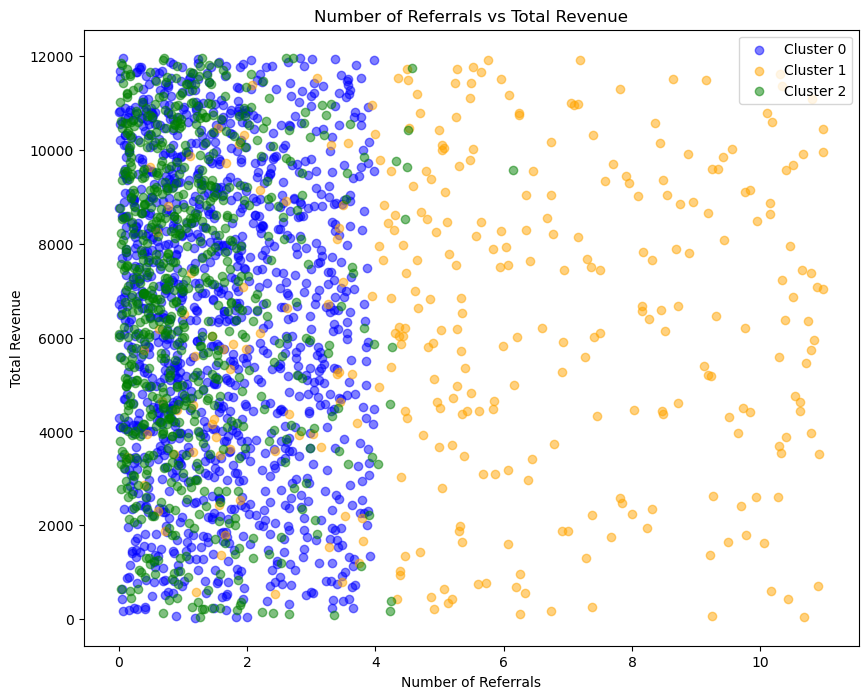

In [12]:
plt.figure(figsize=(10, 8))
colors = {0.0: 'blue', 1.0: 'orange', 2.0: 'green'}
for cluster, color in colors.items():
    subset = df_eda[df_eda['Cluster'] == cluster]
    plt.scatter(subset['number_of_referrals'], subset['total_revenue'], c=color, label=f'Cluster {int(cluster)}', alpha=0.5)

plt.title('Number of Referrals vs Total Revenue')
plt.xlabel('Number of Referrals')
plt.ylabel('Total Revenue')
plt.legend()
plt.show()

Here we can see that customer on Cluster 1 have number of referrals that spread or distributed in all range

## Categorical Distribution

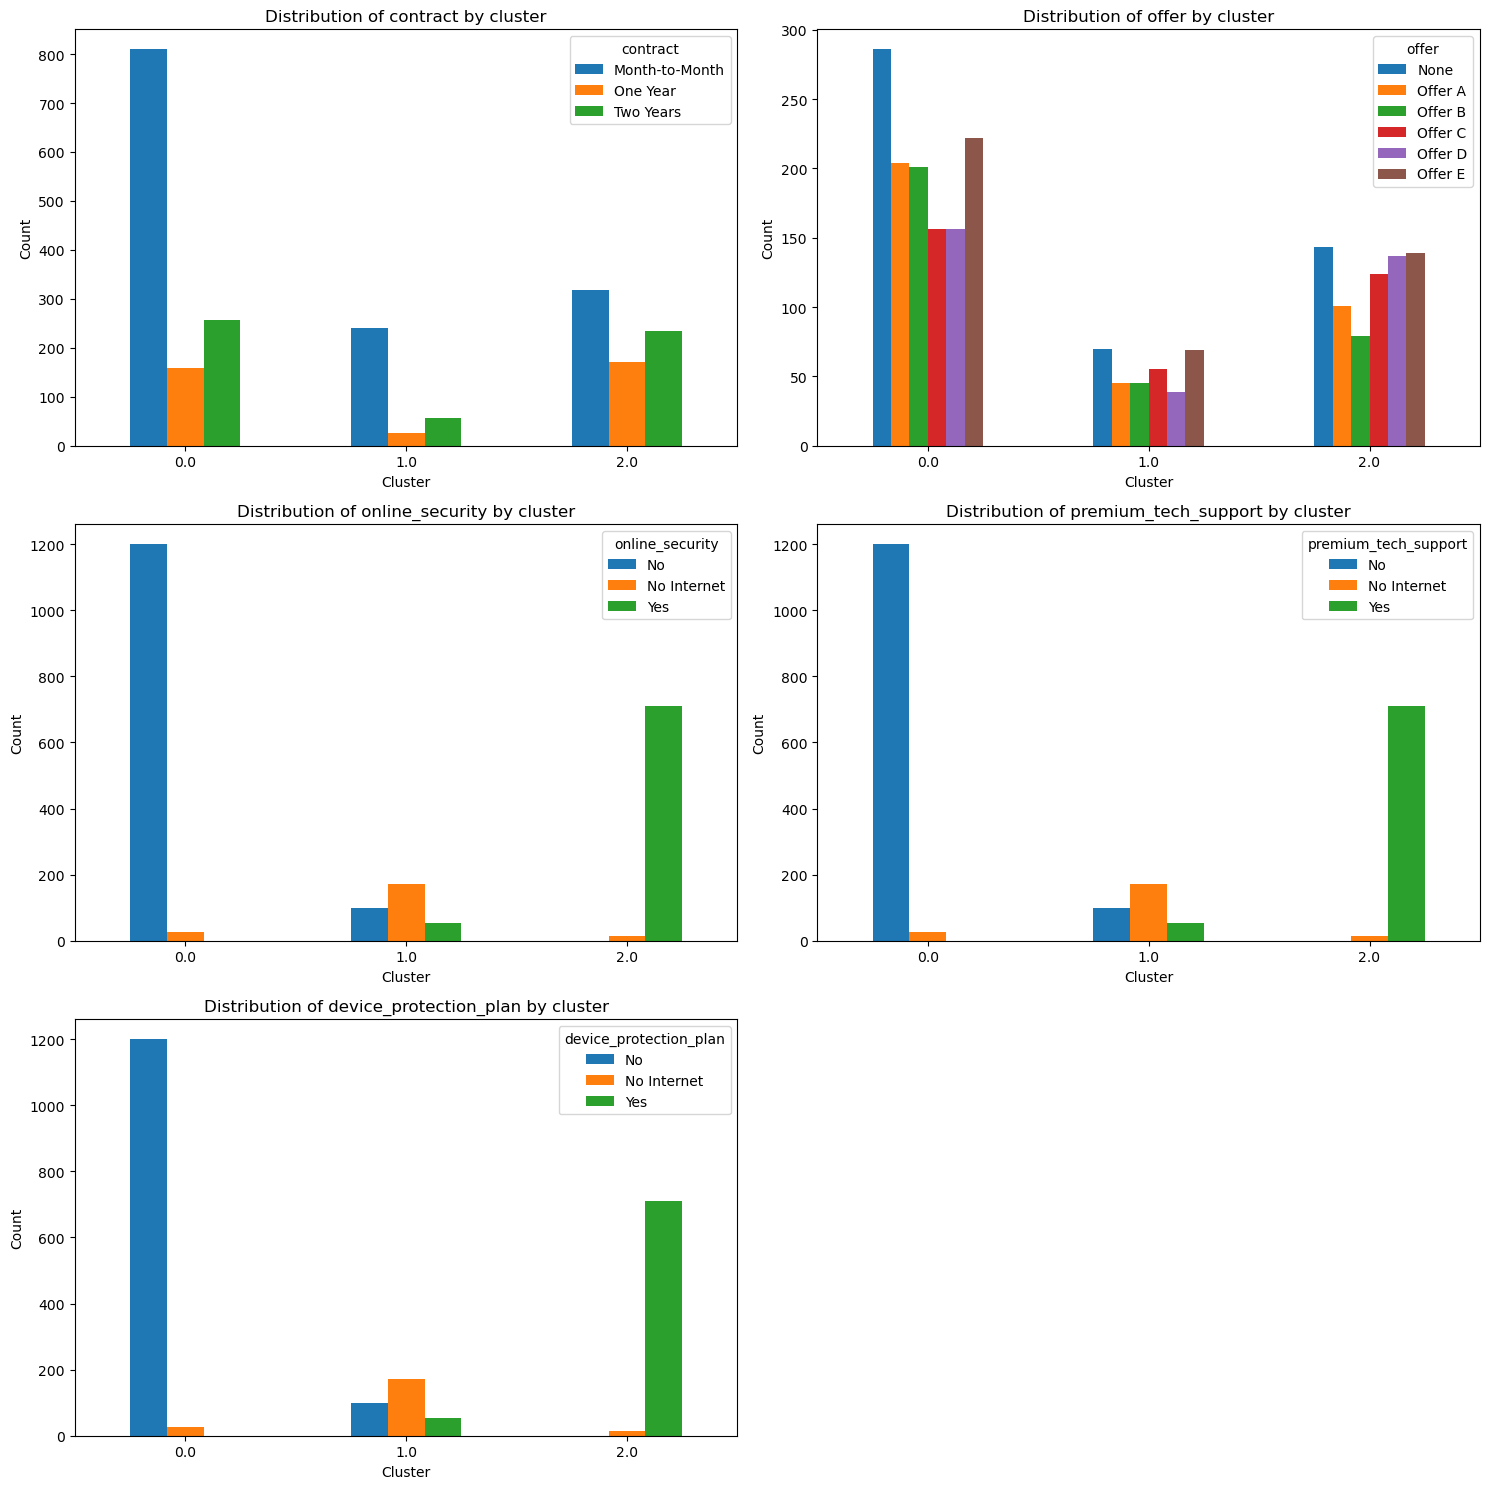

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

categorical_columns = ['contract', 'offer', 'online_security', 'premium_tech_support', 'device_protection_plan']

for ax, column in zip(axes.flatten(), categorical_columns):
    df_eda.groupby(['Cluster', column]).size().unstack().plot(kind='bar', ax=ax)
    ax.set_title(f'Distribution of {column} by cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

**Contract**
- `Month-to-month` type contract have highest value in all cluster
- Cluster 1 have highest `month-to-month` type contract

**Offer**
- `No offer` type have highest value in all cluster
- Cluster 1 have highest `no offer` type contract

**Online Security**, **Premium Tech Support**, & **Device Protection**
- Cluster 0 have highest no service
- Cluster 2 have highest service
- Cluster 1 have highest no internet

# CLUSTER ALIAS

**Cluster 0 as `BLANKSPOT CUSTOMER`**

- Because customer here tends to have no internet service at all or don't want to

**Cluster 1 as `MINIMALIST CUSTOMER`**

- Because customer here tends to have lowest tenure, still refer it to another people, but take no online security, premium support, & device protection service

- They just want basic package

**Cluster 2 as `PREMIUM CUSTOMER`**

- Because customer here have highest online security, premium support, & device protection service

- Seems they want to pay more for another service

# CLUSTER BUSINESS INSIGHT

**`BLANKSPOT CUSTOMER`**

- If there is an opportunity for expansion, consider this cluster for infrastructure improvements
- If not, offer a special no-internet package that might include other services they value

**`MINIMALIST CUSTOMER`**

- Offer them a more attractive basic package or a discount
- Encourage them to commit longer tenure by offering promotions for longer contracts or by providing information about the benefits of additional services

**`PREMIUM CUSTOMER`**

- Maintain quality of service for this cluster
- Consider introducing other new or premium services they might be interested in